In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import rcParams
from skimage import io #import image
import os
import cv2
import h5py
import PIL
import pickle

In [23]:
wls = [
 (325, 414),
 (343, 414),
 (370, 414),
 (343, 451),
 (370, 451),
 (373, 451),
 (343, 575),
 (393, 575),
 (406, 575),
 (441, 575),
 (400, 594),
 (406, 594),
 (431, 594),
 (480, 594),
 (339, 575) # broken
]

def read_image(fn):
    with h5py.File(fn, 'r') as f:
        print('Read metadata about excitation/emission lambdas')
        keys = ['excitationWavelength', 'emission']
        wls = {key: [] for key in keys}
        for key in keys:
            tmp = f['HAC_Image']['imageStruct']['protocol']['channel'][key]
            n_colors = tmp.size
            for i in range(n_colors):
                tmpi = f[f[tmp[i, 0]][0, 0]][:, 0]
                wl = int(tmpi.astype(dtype=np.uint8).tobytes().decode())
                wls[key].append(wl)
        wls['combo'] = []
        for i in range(n_colors):
            wls['combo'].append(
                (wls['excitationWavelength'][i], wls['emission'][i]),
                )

        print('Read image data')
        img = f['HAC_Image']['imageStruct']['data'][:, :, :]
    return {
        'data': img,
        'wavelengths': wls['combo'],
        'image': os.path.basename(fn).split('.')[0],
    }

def cell_labels(seg_fn):    
    print('import segmentated figure')
    if '_T' in seg_fn:
        img = cv2.imread(seg_fn, 2).T # 1: color, 2: gray
    else:
        img = cv2.imread(seg_fn, 2)

    print('get labels of each cell')
    from skimage.segmentation import watershed
    markers = np.zeros_like(img)
    markers[img == 2] = 1
    markers[img == 1] = 2
    segmentation = watershed(img, markers)

    from scipy import ndimage as ndi
    segmentation = ndi.binary_fill_holes(segmentation - 1)

    labeled, _ = ndi.label(segmentation)
    return img, labeled

def plot_image(img, n_ls, fn_mat, labeled, save_path):
    '''
    plot all cells from a grid in all channels
    '''

    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"

    for n in n_ls:
        fig, axs = plt.subplots(3, 5, figsize=(7.87, 4.56), sharex=True, sharey=True, dpi=300)
        axs = axs.ravel()
        px = np.bincount(labeled.ravel()).argsort()[::-1][int(n)]
    
        for i, wl in enumerate(wls):
            row = img[i].copy().T
            row[labeled != px] = 0
            axs[i].imshow(row, interpolation='nearest')
            axs[i].set_title(str(wl[0]) + ' ' + str(wl[1]), fontsize=10)
            axs[i].set_xticks([])
            axs[i].set_yticks([])
        fig.suptitle(fn_mat.split('.')[0] + ' ' + '#' + n)
        fig.tight_layout()
        
        path = save_path + fn_mat.split('.')[0] + '/' 
        folder = os.path.exists(path)
        if not folder: 
            os.makedirs(path) 
        plt.savefig(path + '#' + n + '.png')
        plt.savefig(path + '#' + n + '.pdf')
        

def extract_features(img, n_ls, fn_mat, labeled):
    
    features_all = []
    for n in n_ls:
        px = np.bincount(labeled.ravel()).argsort()[::-1][int(n)]
        raw = img.copy().T     
        raw[:, labeled != px] = 0
    
        img_max = raw.max(axis=0)
        img_bin = img_max > 0
        area = (img_max > 0).sum()
        # Horizontal length
        length = img_bin.any(axis=0).nonzero()[0]
        length = length[-1] - length[0]
        # Vertical width (waist line)
        width = img_bin.any(axis=1).nonzero()[0]
        width = width[-1] - width[0]

        # Eccentricity
        ecc = length / width

        # Spectrum
        spectrum = raw.sum(axis=1).sum(axis=1)

        feas = {
            'area': area,
            'length': length,
            'width': width,
            'eccentricity': ecc,
            'spectrum': spectrum,
            'image': fn_mat.split('.')[0],
            'cell': n, # '#feature'
            'wavelengths': wls
        }

        features_all.append(feas)
        
    features_all = pd.DataFrame(features_all)
    return features_all

def plot_bubble_spectrum(spectrum, wls):
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    
    wls_ex = list(np.unique([x[0] for x in wls]))
    wls_em = list(np.unique([x[1] for x in wls]))
    nex = len(wls_ex)
    nem = len(wls_em)
    smax = spectrum.max()
    snorm = spectrum / smax

    fig, ax = plt.subplots(figsize=(0.5 + 0.4 * nem, 0.1 + 0.4 * nex))
    for (wex, wem), val in zip(wls, snorm):
        x = wls_em.index(wem)
        y = wls_ex.index(wex)
        r = (3 + 97 * val) / 200.
        alpha = 0.2 + 0.8 * val
        h = plt.Circle(
            (x, y), r, ec='none', fc='black', alpha=alpha,
            )
        ax.add_artist(h)
    ax.set_xlim(-0.6, nem - 0.4)
    ax.set_ylim(-0.6, nex - 0.4)
    ax.set_xticks(np.arange(nem))
    ax.set_yticks(np.arange(nex))
    ax.set_xticklabels([str(x) for x in wls_em])
    ax.set_yticklabels([str(x) for x in wls_ex])
    ax.set_xlabel('$\lambda_{emiss}$ [nm]')
    ax.set_ylabel('$\lambda_{exit}$ [nm]')

    fig.tight_layout()
    return {
        'fig': fig,
        'ax': ax,
    }

def em_ex_plot(n_cell, features, image, save_path):
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    rcParams['font.size'] = 10
    
    wls = features['wavelengths'].iloc[0][: -1] # remove the last blank spectra
    wlx, wly = list(zip(*wls))
    
    n_row = (len(n_cell) // 3) + [1, 0][len(n_cell) % 3 == 0]
#     if len(n_cell) < 3:
#         n_col = len(n_cell)
#     else:
#         n_col = 3
    
    fig, axs = plt.subplots(n_row, 3, figsize=(10, 2 * n_row + 1), sharex=True, sharey=True, dpi=300)
    
    axs = axs.ravel()
    
    for i in range(len(n_cell), len(axs)):
        axs[i].remove()

    vmax = np.vstack(features['spectrum']).max()

    for i, ax in enumerate(axs[: len(n_cell)]):
        feas = features.iloc[i]
        spectrum = feas['spectrum']
        cell = feas['cell']

        wlx_label = np.unique(wlx).tolist()
        wly_label = np.unique(wly).tolist()
        for j, ((wlxj, wlyj), val) in enumerate(zip(wls, spectrum)):
            x = wlx_label.index(wlxj)
            y = wly_label.index(wlyj)
            val_norm = (val + 1) / (vmax +1)
            s = 0.05 + 0.45 * val_norm
#             alpha = 0.3 + 0.7 * val_norm
            alpha = val_norm
            h = plt.Circle((x, y), s, color='red', alpha=alpha)
            ax.add_artist(h)
        
        title = ' #' + cell + ' ' + features.index[i]
        ax.set_title(title)
        ax.set_yticks(np.arange(len(wly_label)))
        ax.set_xticks(np.arange(len(wlx_label)))
        ax.set_xlim(-0.6, len(wlx_label) - 0.4)
        ax.set_ylim(-0.6, len(wly_label) - 0.4)

        ax.set_xticklabels(wlx_label, rotation=90)
        ax.set_yticklabels(wly_label)

    #fig.text(0.52, 0.02, '$\lambda_{exit}$ [nm]', ha='center')
    #fig.text(0.02, 0.52, '$\lambda_{emiss}$ [nm]', rotation=90, va='center')
    plt.suptitle('Spectra of ' + image, y=1)
    fig.supxlabel('$\lambda_{exit}$ [nm]', ha='center', va='center')
    fig.supylabel('$\lambda_{emiss}$ [nm]', ha='center', va='center')
    fig.tight_layout()
    
    plt.savefig(save_path + image + '.png', bbox_inches = 'tight')
    plt.savefig(save_path + image + '.pdf', bbox_inches = 'tight')
    plt.clf()

In [24]:
# plot spectra of a whole grid
if True:
    save_path = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/spectra/'

    seg_fdn = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/good_seg/'
    fn_out = seg_fdn +'features.pkl'
    with open(fn_out, 'rb') as f:
        features = pickle.load(f)
    features = features[(features['doublets'] == 'No') & (features['#cells'] == 1)]

    for image in features['image'].unique():
        fi = features[features['image'] == image]
        n_cell = fi.index.tolist()

        em_ex_plot(n_cell, fi, image, save_path)

<ipython-input-23-21011ac92e10>:186: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(n_row, 3, figsize=(10, 2 * n_row + 1), sharex=True, sharey=True, dpi=300)


<Figure size 3000x1500 with 0 Axes>

<Figure size 3000x1500 with 0 Axes>

<Figure size 3000x1500 with 0 Axes>

<Figure size 3000x900 with 0 Axes>

<Figure size 3000x1500 with 0 Axes>

<Figure size 3000x2100 with 0 Axes>

<Figure size 3000x900 with 0 Axes>

<Figure size 3000x900 with 0 Axes>

<Figure size 3000x900 with 0 Axes>

<Figure size 3000x900 with 0 Axes>

<Figure size 3000x900 with 0 Axes>

<Figure size 3000x2100 with 0 Axes>

<Figure size 3000x900 with 0 Axes>

<Figure size 3000x900 with 0 Axes>

<Figure size 3000x1500 with 0 Axes>

<Figure size 3000x900 with 0 Axes>

<Figure size 3000x1500 with 0 Axes>

<Figure size 3000x900 with 0 Axes>

<Figure size 3000x1500 with 0 Axes>

<Figure size 3000x1500 with 0 Axes>

<Figure size 3000x900 with 0 Axes>

<Figure size 3000x900 with 0 Axes>

<Figure size 3000x900 with 0 Axes>

<Figure size 3000x900 with 0 Axes>

<Figure size 3000x900 with 0 Axes>

<Figure size 3000x900 with 0 Axes>

In [11]:
def plot_seg(cell, seg, labeled, n_ls, save_path):
    
    raw = seg.copy()
    px = [np.bincount(labeled.ravel()).argsort()[::-1][int(i)] for i in n_ls]
    raw[ ~ np.isin(labeled, px)] = 2

    fig, ax = plt.subplots(figsize=(2, 2), dpi=300)
    ax.imshow(raw)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    path = save_path + cell + '/'
    folder = os.path.exists(path)
    if not folder: 
        os.makedirs(path) 
    plt.savefig(path + cell + '_seg.png')
    #plt.savefig(path + cell + '_seg.pdf')
    
    np.savetxt(path + cell + '_seg.txt')
    
####################
def plot_image(img, cell, n_ls, labeled, save_path):
    '''
    plot all cells from a grid in all channels
    '''

    for n in n_ls:
        for i, wl in enumerate(wls):
            fig, ax = plt.subplots(figsize=(2, 2), dpi=300)
            px = [np.bincount(labeled.ravel()).argsort()[::-1][int(i)] for i in n_ls]
            
            for i in range(img.shape[0]):
                img[0] = img[0].T
            raw = img[i].copy()
            raw[ ~ np.isin(labeled, px)] = 0
            ax.imshow(raw, interpolation='nearest')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            fig.tight_layout()

            path = save_path + cell + '/'
            folder = os.path.exists(path)
            if not folder: 
                os.makedirs(path) 
            plt.savefig(path + cell + '_' + wl[0] + '_' + [wl[1]] + '.png')
            
################################################
print('load segmentation information')
df = pd.read_csv('/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/raw_with_gene_names_obs.tsv', 
                 sep='\t', index_col=0)

n_cells = {}
for grid in df[: -4]['grid'].unique():
    n_cells[grid] = {}
    cells = df[df['grid'] == grid].index

    for cell in cells:
        if ',' in df.loc[cell]['#feature']:
            n_ls = df.loc[cell]['#feature'].split(',')
        else:
            n_ls = [df.loc[cell]['#feature']]
        n_cells[grid][cell] = n_ls

###########

if False:
    seg_fdn = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/good_seg/'
    fdn_mat = '/home/yike/phd/cancer_cells_img_seq/data/20220201_imaging/'
    save_path = '/home/yike/phd/cancer_cells_img_seq/figures/segmentation/figures/'

    fns = [i for i in os.listdir(seg_fdn) if 'tiff' in i]

    for i, fn in enumerate(fns):
        if '_T' in fn:
            grid = fn.split('.')[0][:-22]
        else:
            grid = fn.split('.')[0][:-20]

        print('___________________________')
        print('{} dish {}'.format(i, grid))
        print('get labeled arrays')

        seg, labeled = cell_labels(seg_fdn + fn)

        print('get image date')
        fn_mat = grid + '.mat'
        img = read_image(fdn_mat + fn_mat)['data']

        cells = n_cells[grid].keys()
        for cell in cells:
            n_ls = n_cells[grid][cell]

            if n_ls == ['FALSE']:
                continue

            print('plot single segmentation and save arrays')
            plot_seg(cell, seg, labeled, n_ls, save_path)

            print('plot single cells')
            plot_image(img, cell, n_ls, labeled, save_path)

load segmentation information


In [3]:
# transfer segmented figures from tiff to png
if False:
    seg_fd = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/Nor_RGB_figs_3_5_6/need_seg4/'
    
    fns = [i for i in os.listdir(seg_fd) if 'Simple Segmentation.tiff' in i]

    for fn in fns:
        img = cv2.imread(seg_fd + fn, 2)
        plt.imshow(img)
        plt.savefig(seg_fd + 'seg/' + fn.split('.')[0] + '.png')

In [4]:
# get segmented figures to show cell position
if False:
    seg_fdn = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/good_seg/'
    fns = [i for i in os.listdir(seg_fdn) if 'tiff' in i]

    for fn in fns:
        print('get labeled arrays')
        labeled = cell_labels(seg_fdn + fn)

        ##################
        if '_T' in fn:
            img = cv2.imread(seg_fdn + fn, 2).T # 1: color, 2: gray
        else:
            img = cv2.imread(seg_fdn + fn, 2)

        fig, axs = plt.subplots(4,3, dpi=300, figsize=(8, 6)) 
        plt.subplots_adjust(wspace=0.2, hspace=0.2)
        axs = axs.ravel()
        for i, px in enumerate(np.bincount(labeled.ravel()).argsort()[::-1][1: 13]):
            a = img.copy()
            a[labeled != px] = 0
            axs[i].imshow(a)
            axs[i].axis('off')
            axs[i].set_title(i + 1)
        plt.tight_layout()
        plt.savefig(seg_fdn + 'seg/' + fn.split('_')[0] + '_' + fn.split('_')[1] + 'seg'+ '.png')

In [5]:
if False:
    print('load segmentation information')
    df = pd.read_csv('/home/yike/projects/imaging-sequencing/data/20220201_imaging/good_seg/raw_with_gene_names_obs.tsv', 
                     sep='\t', index_col=0)

    n_cells = {}
    for grid in df[: -4]['Grid'].unique():
        n_ls = df[df['Grid'] == grid]['#feature'].tolist()

        if 'FALSE' in n_ls:
            n_ls.remove('FALSE')

        n_ls_new = []
        for i in n_ls:
            if ',' not in i:
                n_ls_new.append(i)
            else:
                n_ls_new = n_ls_new + i.split(',')

        n_cells[grid] = np.unique(n_ls_new).tolist()

    # get roughly features
    seg_fdn = '/home/yike/projects/imaging-sequencing/data/20220201_imaging/good_seg/'
    fdn_mat = '/home/yike/projects/imaging-sequencing/data/20220201_imaging/mat_fd/'
    save_path = '/home/yike/projects/imaging-sequencing/data/20220201_imaging/seg_cells/'

    fns = [i for i in os.listdir(seg_fdn) if 'tiff' in i]

    features = pd.DataFrame([])

    for i, fn in enumerate(fns):
        if '_T' in fn:
            grid = fn.split('.')[0][:-22]
        else:
            grid = fn.split('.')[0][:-20]
        print('___________________________')
        print('{} dish {}'.format(i, grid))
        print('get labeled arrays')
        n_ls = n_cells[grid]
        labeled = cell_labels(seg_fdn + fn)

        print('get image date')
        fn_mat = grid + '.mat'
        img = read_image(fdn_mat + fn_mat)['data']

        print('plot segmented cells')
        plot_image(img, n_ls, fn_mat, labeled, save_path)
        print('extract features of each cell')
        fes = extract_features(img, n_ls, fn_mat, labeled)
        features = pd.concat([features, fes], axis=0)

    # save features as a pickle file
    import pickle
    with open(seg_fdn + 'features.pkl', 'wb') as f:
        pickle.dump(features, f)

In [8]:
# edit features.pkl, add sample name
if False:
    import pickle
    seg_fdn = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/good_seg/'
    fn_out = seg_fdn +'features2.pkl'
    with open(fn_out, 'rb') as f:
        features = pickle.load(f)

    ###############################
    obsmeta = '/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/raw_with_gene_names_obs.tsv'
    obs = pd.read_csv(obsmeta, sep='\t', index_col=0)

    sample_ls = []
    for _, row in features.iterrows():
        image = row['image']
        cell = row['cell']
        if len(obs[(obs['grid'] == image) & (obs['#feature'] == cell)].index) > 0:
            sample = obs[(obs['grid'] == image) & (obs['#feature'] == cell)].index[0]
        else:
            obs_i = obs[obs['grid'] == image]
            for i, rowi in obs_i.iterrows():
                if ',' in rowi['#feature']:
                    if cell in rowi['#feature'].split(','):
                        sample = obs_i[(obs_i['grid'] == image) & (obs_i['#feature'] == rowi['#feature'])].index[0]
        sample_ls.append(sample)
    features['sample'] = sample_ls
    
    features.set_index('sample', inplace=True)
    features['doublets'] = obs.loc[features.index]['doublets']
    features['#cells'] = obs.loc[features.index]['#cells']
    with open(seg_fdn + 'features2.pkl', 'wb') as f:
        pickle.dump(features, f)

plot bubble spectrum


<ipython-input-2-71e6c60dbedb>:147: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(0.5 + 0.4 * nem, 0.1 + 0.4 * nex))


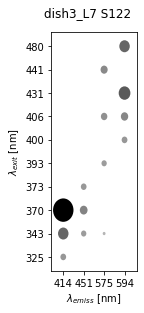

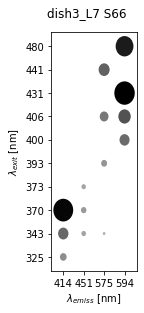

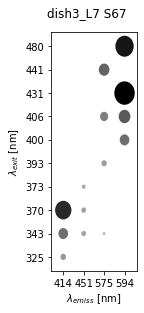

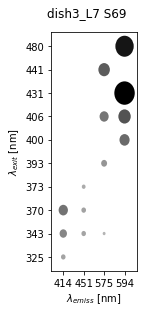

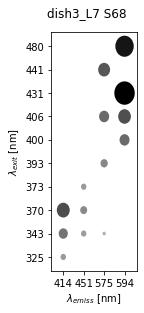

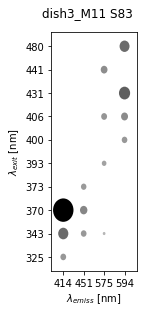

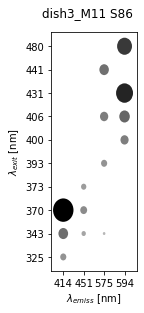

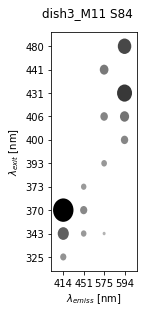

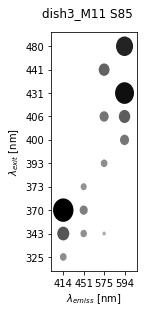

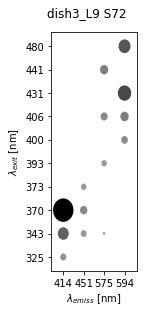

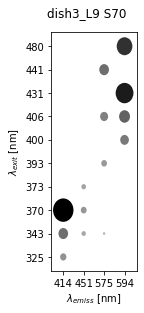

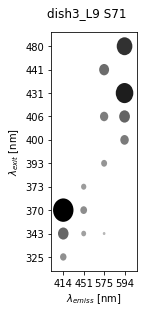

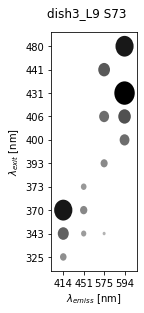

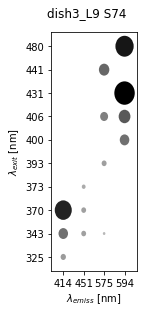

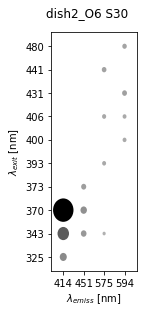

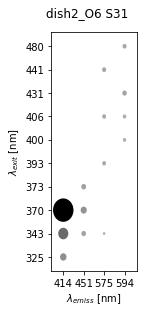

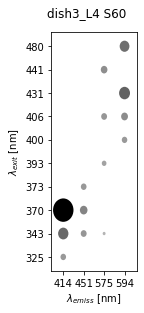

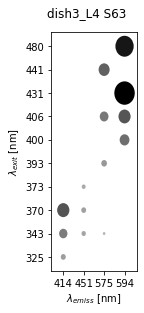

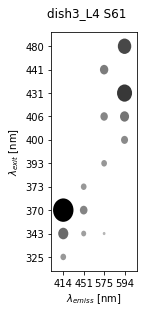

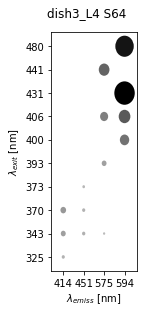

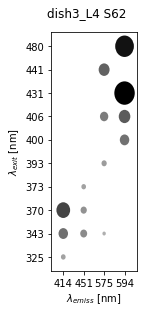

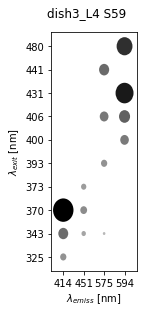

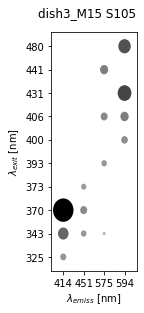

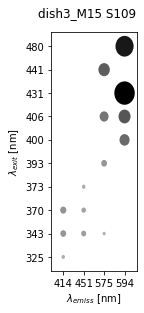

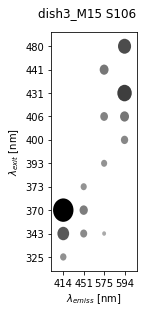

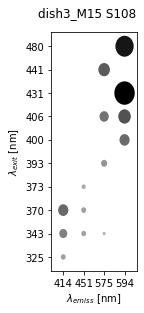

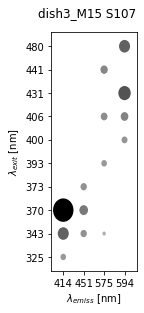

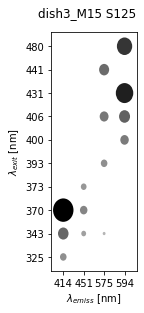

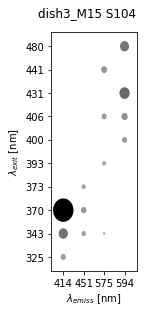

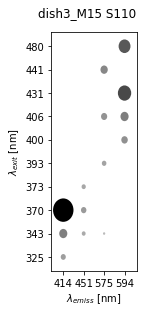

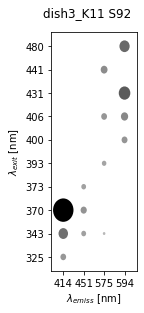

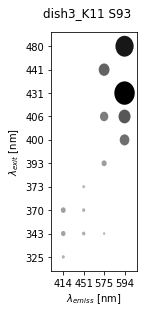

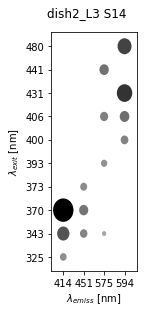

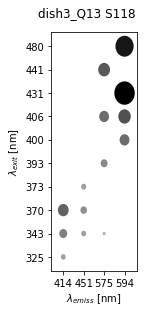

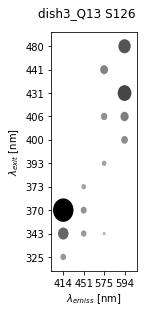

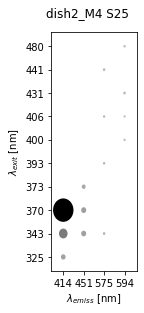

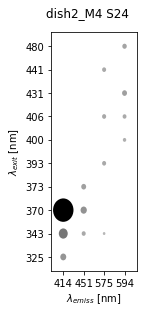

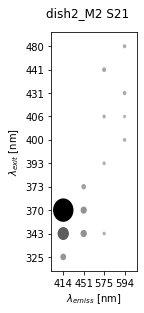

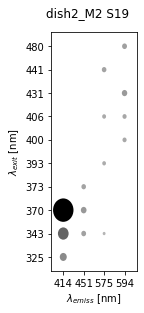

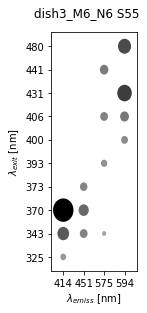

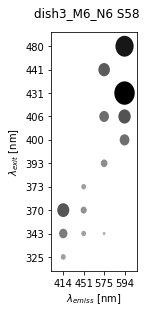

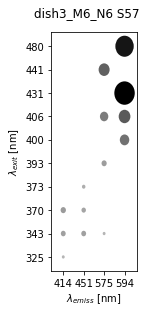

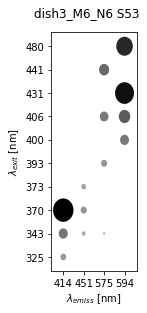

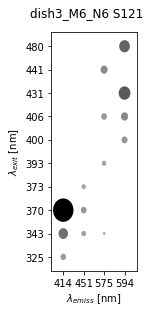

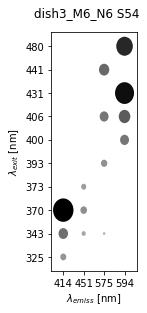

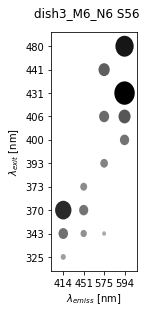

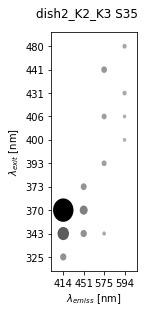

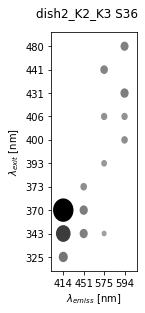

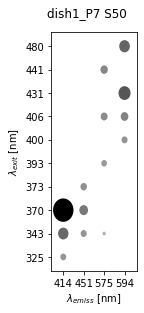

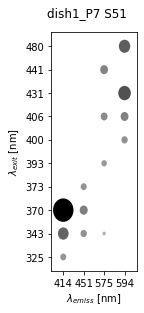

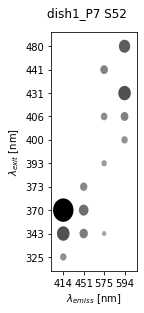

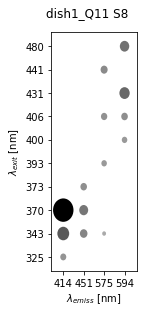

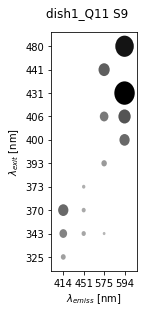

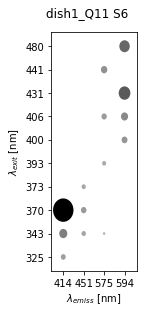

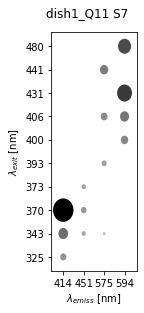

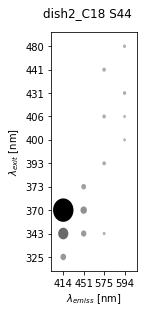

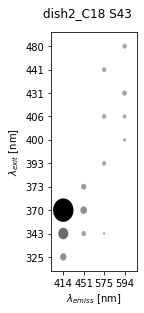

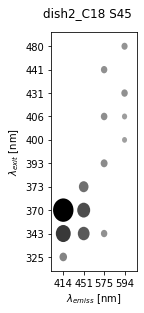

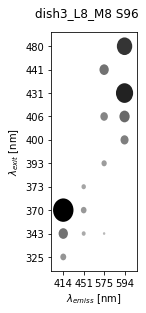

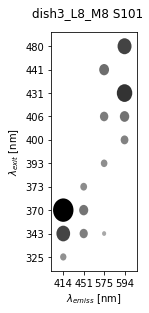

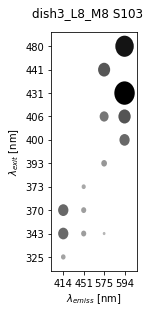

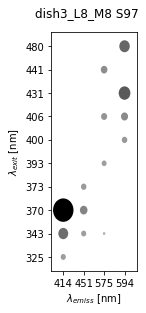

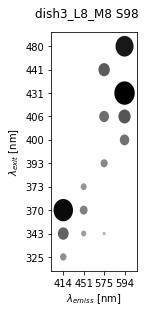

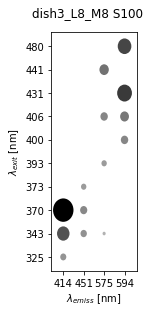

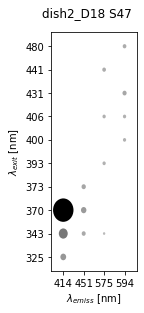

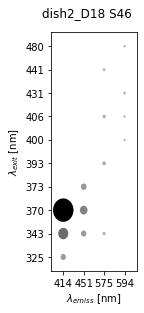

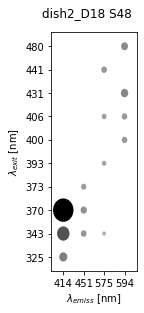

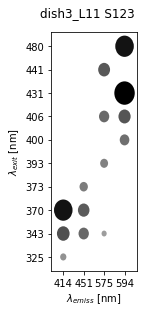

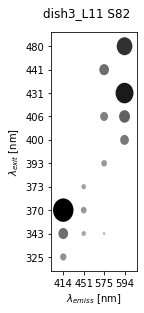

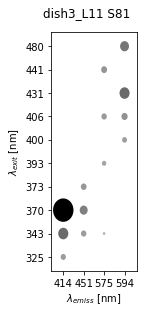

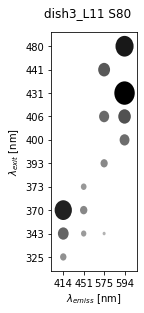

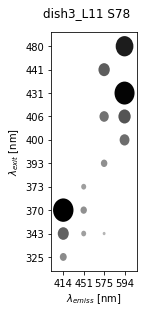

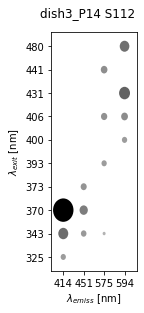

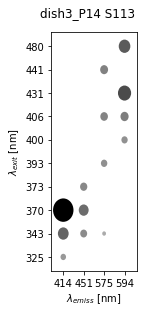

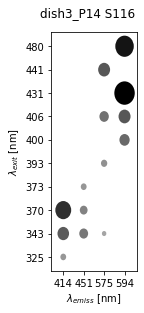

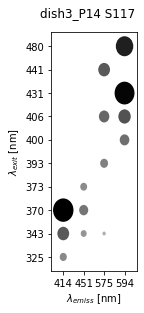

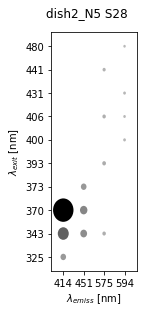

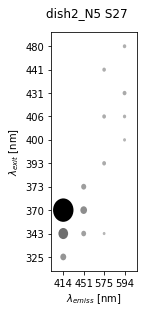

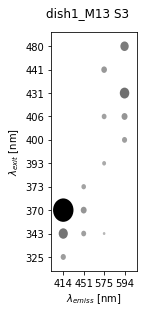

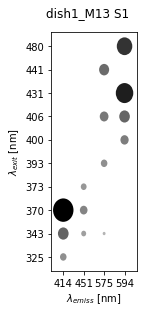

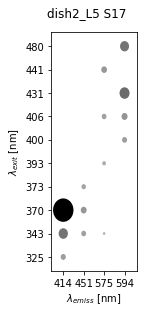

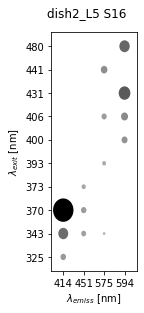

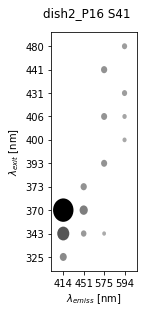

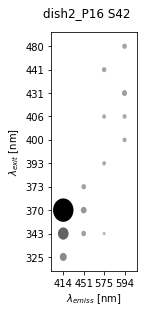

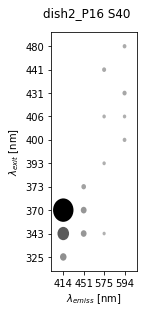

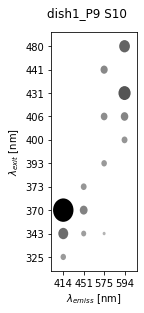

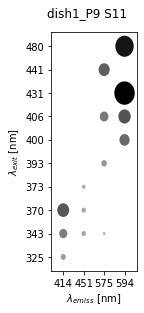

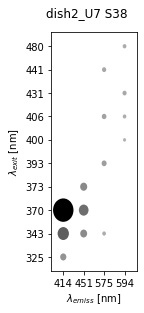

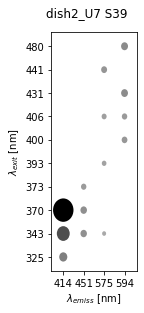

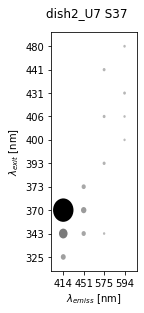

In [10]:
# plot bubble spectrum for single cells 
if False:
    seg_fdn = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/good_seg/'
    fn_out = seg_fdn +'features.pkl'
    with open(fn_out, 'rb') as f:
        features = pickle.load(f)

    print('plot bubble spectrum')
    cells = features[(features['doublets'] == 'No') & (features['#cells'] == 1)]

    bubble_path = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/bubble_spectrum/'
    for image in cells['image'].unique():
        cellsi = cells[cells['image'] == image]
        for index in cellsi.index:
            wlsi = cells.loc[index]['wavelengths']
            grid = cells.loc[index]['image']
            cell = cells.loc[index]['cell']
            s = index.split('_')[1]

            # remove (339, 575)
            bb_plot = plot_bubble_spectrum(cells.loc[index]['spectrum'][:-1], wlsi[:-1])['fig']
            title = grid + ' ' + s
            bb_plot.suptitle(title, x=0.6, y=1.05)
            bb_plot.tight_layout()

            path = bubble_path + image + '/'
            folder = os.path.exists(path)
            if not folder:
                os.makedirs(path)
            bb_plot.savefig(path + title + '_bubble.png', bbox_inches='tight')
            bb_plot.savefig(path + title + '_bubble.pdf', bbox_inches='tight')

In [18]:
# plot spectra of a whole grid
if False:
    save_path = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/spectra/'

    seg_fdn = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/good_seg/'
    fn_out = seg_fdn +'features.pkl'
    with open(fn_out, 'rb') as f:
        features = pickle.load(f)
    features = features[(features['doublets'] == 'No') & (features['#cells'] == 1)]

    for image in features['image'].unique():
        fi = features[features['image'] == image]
        n_cell = fi.index.tolist()

        em_ex_plot(n_cell, fi, image, save_path)

<ipython-input-17-8b390a6556b8>:185: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(n_row, 3, figsize=(3 * n_col, 2 * n_row), sharex=True, sharey=True, dpi=300)


<Figure size 2700x1200 with 0 Axes>

<Figure size 2700x1200 with 0 Axes>

<Figure size 2700x1200 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 2700x1200 with 0 Axes>

<Figure size 2700x1800 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 2700x1800 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 2700x600 with 0 Axes>

<Figure size 2700x1200 with 0 Axes>

<Figure size 2700x600 with 0 Axes>

<Figure size 2700x1200 with 0 Axes>

<Figure size 2700x600 with 0 Axes>

<Figure size 2700x1200 with 0 Axes>

<Figure size 2700x1200 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 2700x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 2700x600 with 0 Axes>